In [44]:
from PIL import Image
import time
import numpy as np
import pandas as pd
import sys
import os
from tqdm import trange
import matplotlib.pyplot as plt

## Data

In [27]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("getomni-ai/ocr-benchmark")

print(type(ds))

<class 'datasets.dataset_dict.DatasetDict'>


In [28]:
data = ds['test']

## Models

In [29]:
ocr_models = {} # {model_name: handler_func}

### apple-ocr

Reformatted the output for benchmark consistency.
```
Before parsing:
[
  (
    text: str,
    confidence: float,
    [bbox.origin.x: float, bbox.origin.y: float, bbox.size.width: float, bbox.size.height: float]
  ), ...
]
Apple:
bbox: The coordinates of the bounding box are normalized to the dimensions of the processed image, with the origin at the lower-left corner of the image.
confidence: A normalized confidence score for the text recognition result.
```

In [30]:
module_path = './models/apple-ocr/src'
sys.path.append(os.path.abspath(module_path))
from apple_ocr import ocr

def apple_ocr_handler(image):
  def parse_apple_ocr_result(data, w, h):
    output = []
    for instance in data:
      bbox = instance[2]
      origin_x_normalized = bbox[0]
      origin_y_normalized = bbox[1]
      width_normalized = bbox[2]
      height_normalized = bbox[3]

      x1 = origin_x_normalized * w
      y1 = origin_y_normalized * h
      x2 = x1 + (width_normalized * w)
      y2 = y1 + (height_normalized * h)
      x1, y1, x2, y2 = np.int32(round(x1)), np.int32(round(y1)), np.int32(round(x2)), np.int32(round(y2))

      output.append({
        'text': instance[0],
        'confidence': instance[1],
        'bbox': [
            [x1, y2], # top left
            [x2, y2], # top right
            [x1, y1], # bottom left
            [x2, y1]  # bottom right
          ]
      })
    return output

  start_time = time.time()
  apple_ocr = ocr.OCR(image=image)
  end_time = time.time()
  setup_time = end_time - start_time

  image_width, image_height = image.size

  start_time = time.time()
  df = apple_ocr.recognize()
  end_time = time.time()
  runtime = end_time - start_time

  # Before parsing:
  # [
  #   (
  #     text: str,
  #     confidence: float,
  #     [bbox.origin.x: float, bbox.origin.y: float, bbox.size.width: float, bbox.size.height: float]
  #   ), ...
  # ]
  # Apple:
  # bbox: The coordinates of the bounding box are normalized to the dimensions of the processed image, with the origin at the lower-left corner of the image.
  # confidence: A normalized confidence score for the text recognition result.
  out = apple_ocr.data
  return parse_apple_ocr_result(out, image_width, image_height), runtime, setup_time

ocr_models['apple-ocr'] = apple_ocr_handler

### easy-ocr

In [31]:
import easyocr
def easyocr_handler(image):
  def parse_easyocr_result(data):
    output = []
    for instance in data:
      output.append(
        {
          'text': instance[1],
          'confidence': instance[2],
          'bbox': instance[0]
        }
      )
    return output

  image = np.array(image)

  start_time = time.time()
  reader = easyocr.Reader(['en'])  # specify language
  end_time = time.time()
  setup_time = end_time - start_time
  # Before parsing:
  # [
  #   (
  #     [[x1, y1], [x2, y2], [x3, y3], [x4, y4]],
  #     text: str, 
  #     confidence: np.float64
  #   ), ...
  # ]
  start_time = time.time()
  results = reader.readtext(image)
  end_time = time.time()
  runtime = end_time - start_time
  return parse_easyocr_result(results), runtime, setup_time

ocr_models['easy-ocr'] = easyocr_handler

### tesseract-ocr

Note: On MacOS, the `pytesseract` python package is just a wrapper. Need to also `brew install tesseract`.

In [ ]:
import pytesseract
def tesseract_ocr_handler(image):
  start_time = time.time()
  out = pd.DataFrame(pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT))
  # out = pytesseract.image_to_string(image)
  end_time = time.time()
  runtime = end_time - start_time

  return out, runtime, 'N/A'

ocr_models['tesseract-ocr'] = tesseract_ocr_handler


In [33]:
# img = data[99]['image']
# tesseract_ocr_handler(img)

## Run

Note this is run a with single image, different models may have varying performances with batched processing.

In [36]:
img = data[99]['image'] # Just test with one image for now

for name, handler in ocr_models.items():
  print(f'=========== {name} ===========')
  out, runtime, setup_time = handler(img)
  df = pd.DataFrame(out)
  print(f'Setup Time: {setup_time}\nRuntime: {runtime}')
  print("---- Output ----")
  print(df['text'].head(10))
  print(f'')

=========== apple-ocr ===========
Setup Time: 1.7881393432617188e-05
Runtime: 0.6121931076049805
---- Output ----
0            Staff Shift Schedule
1    Fort Bradlv Medical Center -
2      Week of September 27, 2025
3                        Employee
4                Courtney Lebsack
5                     Linda Lesch
6                   Roberto Stehr
7                Horace Gleichner
8                    Stella Fadel
9                Jared Leannon II
Name: text, dtype: object

=========== easy-ocr ===========
Setup Time: 2.2657580375671387
Runtime: 5.501737833023071
---- Output ----
0          Staff Shift Schedule
1                          Fort
2         Bradly Medical Center
3    Week of September 27, 2025
4                      Employee
5                            ID
6                    Department
7                        Sat 27
8                        Sun 28
9                        Mon 29
Name: text, dtype: object

=========== tesseract-ocr ===========
Setup Time: N/A
Runtime: 2

Testing by averaging runtime across multiple images.

In [43]:
# Runtime comparisons
n = 10

runtimes = {name: [] for name, _ in ocr_models.items()}

for i in trange(n, desc='img'):
  img = data[n]['image']

  for name, handler in ocr_models.items():
    out, runtime, setup_time = handler(img)
    if not isinstance(setup_time, float):
      setup_time = 0
    runtimes[name].append(runtime + setup_time)

img: 100%|██████████| 10/10 [00:38<00:00,  3.80s/it]


In [45]:
# Averages
print(f'Average runtimes across {n} images')
for name, lst in runtimes.items():
  times = np.array(lst)
  print(f'--- {name}:')
  print(f'Average time: {np.mean(times)}')

Average runtimes across 10 images
--- apple-ocr:
Average time: 0.18556158542633056
--- easy-ocr:
Average time: 3.2178409814834597
--- tesseract-ocr:
Average time: 0.39606475830078125


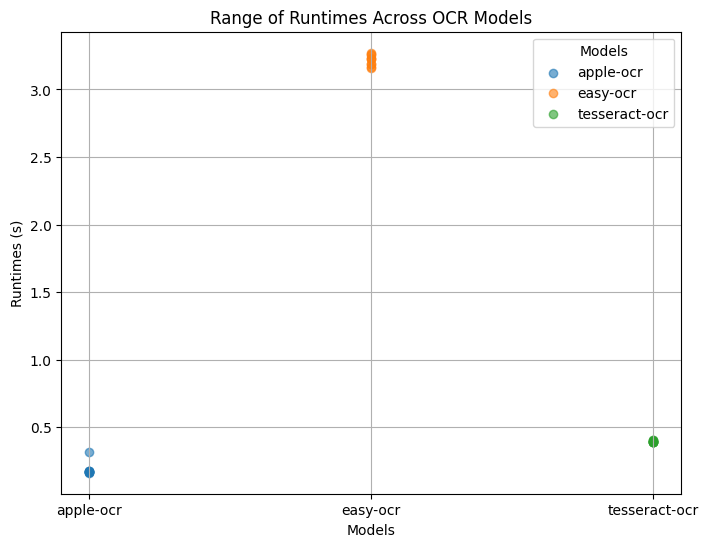

In [48]:
# Plot
plt.figure(figsize=(8, 6))

for i, (key, values) in enumerate(runtimes.items()):
    plt.scatter([key] * len(values), values, label=key, alpha=0.6)

plt.xlabel('Models')
plt.ylabel('Runtimes (s)')
plt.title('Range of Runtimes Across OCR Models')

plt.legend(title="Models")
plt.grid(True)

plt.show()